# **Prepare Data**

In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import pandas as pd
import seaborn as sns

from category_encoders import OneHotEncoder

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline

# Disable the SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

## Import

In [ ]:
# Load data
df1 = pd.read_csv("/content/drive/MyDrive/DataScienceProjects/020 Housing-in-buenos-aires/data/buenos-aires-real-estate-1.csv")
df1.head(2)

,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
0,sell,apartment,|Argentina|Capital Federal|Villa Crespo|,"-34.6047834183,-58.4586812499",180000.0,USD,2729232.0,180000.0,120.0,110.0,1500.000000,1636.363636,NaN,4.0,NaN,http://villa-crespo.properati.com.ar/12egq_ven...
1,sell,house,|Argentina|Bs.As. G.B.A. Zona Oeste|La Matanza...,NaN,250000.0,USD,3790600.0,250000.0,117.0,120.0,2136.752137,2083.333333,NaN,4.0,NaN,http://ramos-mejia.properati.com.ar/s7pd_venta...


### Overview

We want to predict the price of houses in `Buenos-Aires`, `Capital Federal` district which are less than `400 000` USD.


## Explore

> ### Function for data preparation

In [ ]:
# Creating a function to prepare data
def prepare_data(path):
  
    # Read CSV file
    df = pd.read_csv(path)

    # Subset data: houses in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_hse = df["property_type"] == "house"
    mask_price = df["price_aprox_usd"] < 400_000

    # filter dataset
    df = df[mask_ba & mask_hse & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns = "lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)
        
    # Drop features with high null counts
    df.drop(columns=["floor", "expenses"], inplace=True)
    
    # Drop low- and high-cardinality categorical features
    df.drop(columns=["property_type","operation","currency","properati_url"], inplace=True)
    
    # Drop leaky features
    df.drop(
        columns=
        ['price',
        'price_aprox_local_currency',
        'price_per_m2',
        'price_usd_per_m2'], inplace=True)
    
    # Drop features with high collinearity
    df.drop(columns=['surface_total_in_m2','rooms'], inplace=True)
    
    return df


#### 1. Filtering using boolean mask

In [ ]:
# Subset data: houses in "Capital Federal", less than 400,000
mask_cap= df1["place_with_parent_names"].str.contains("Capital Federal")
mask_hses = df1["property_type"] == "house"
mask_price = df1["price_aprox_usd"] < 400_000

# filter data
df2 = df1[mask_cap & mask_hses & mask_price]
df2.head()

,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
184,sell,house,|Argentina|Capital Federal|Flores|,"-34.6374837,-58.4601452",239000.0,USD,3623813.6,239000.0,150.0,144.0,1593.333333,1659.722222,NaN,NaN,NaN,http://flores.properati.com.ar/12pgl_venta_cas...
195,sell,house,|Argentina|Capital Federal|Boca|,"-34.628398,-58.3619026",240000.0,USD,3638976.0,240000.0,146.0,135.0,1643.835616,1777.777778,NaN,5.0,NaN,http://boca.properati.com.ar/10t85_venta_casa_...
275,sell,house,|Argentina|Capital Federal|Saavedra|,"-34.5459622,-58.4770866",380000.0,USD,5761712.0,380000.0,300.0,280.0,1266.666667,1357.142857,NaN,NaN,NaN,http://saavedra.properati.com.ar/112xx_venta_c...
346,sell,house,|Argentina|Capital Federal|Mataderos|,"-34.6593562,-58.5167781",380000.0,USD,5761712.0,380000.0,225.0,160.0,1688.888889,2375.000000,NaN,4.0,NaN,http://mataderos.properati.com.ar/1087y_venta_...
439,sell,house,|Argentina|Capital Federal|Villa Lugano|,"-34.6632794,-58.4795435",250000.0,USD,3790600.0,250000.0,230.0,190.0,1086.956522,1315.789474,NaN,4.0,NaN,http://villa-lugano.properati.com.ar/yd6n_vent...


#### 2. Remove Outliers

In [ ]:
low, high = df2["surface_covered_in_m2"].quantile([0.1, 0.9])
df2["surface_covered_in_m2"].between(low, high)

184      True
195      True
275     False
346      True
439      True
        ...  
8037    False
8093    False
8466     True
8564     True
8600     True
Name: surface_covered_in_m2, Length: 102, dtype: bool

In [ ]:
# Remove outliers
low, high = df2["surface_covered_in_m2"].quantile([0.1, 0.9])

# subsetting based on quantiles
mask_area = df2["surface_covered_in_m2"].between(low, high)
df3 = df2[mask_area]
df3.head(4)

,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
184,sell,house,|Argentina|Capital Federal|Flores|,"-34.6374837,-58.4601452",239000.0,USD,3623813.6,239000.0,150.0,144.0,1593.333333,1659.722222,NaN,NaN,NaN,http://flores.properati.com.ar/12pgl_venta_cas...
195,sell,house,|Argentina|Capital Federal|Boca|,"-34.628398,-58.3619026",240000.0,USD,3638976.0,240000.0,146.0,135.0,1643.835616,1777.777778,NaN,5.0,NaN,http://boca.properati.com.ar/10t85_venta_casa_...
346,sell,house,|Argentina|Capital Federal|Mataderos|,"-34.6593562,-58.5167781",380000.0,USD,5761712.0,380000.0,225.0,160.0,1688.888889,2375.000000,NaN,4.0,NaN,http://mataderos.properati.com.ar/1087y_venta_...
439,sell,house,|Argentina|Capital Federal|Villa Lugano|,"-34.6632794,-58.4795435",250000.0,USD,3790600.0,250000.0,230.0,190.0,1086.956522,1315.789474,NaN,4.0,NaN,http://villa-lugano.properati.com.ar/yd6n_vent...


#### 3. String split to engineer new features

In [ ]:
# Split "lat-lon" column
df3[["lat", "lon"]]  = df3["lat-lon"].str.split(",", expand=True).astype(float)
df3.drop(columns="lat-lon", inplace=True)
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71 entries, 184 to 8600
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   71 non-null     object 
 1   property_type               71 non-null     object 
 2   place_with_parent_names     71 non-null     object 
 3   price                       71 non-null     float64
 4   currency                    71 non-null     object 
 5   price_aprox_local_currency  71 non-null     float64
 6   price_aprox_usd             71 non-null     float64
 7   surface_total_in_m2         48 non-null     float64
 8   surface_covered_in_m2       71 non-null     float64
 9   price_usd_per_m2            44 non-null     float64
 10  price_per_m2                71 non-null     float64
 11  floor                       0 non-null      float64
 12  rooms                       48 non-null     float64
 13  expenses                    0 non

In [ ]:
# Get place name
df3["neighborhood"] = df3["place_with_parent_names"].str.split("|", expand=True)[3]
df3.drop(columns="place_with_parent_names", inplace=True)
df3.head()

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
184,sell,house,239000.0,USD,3623813.6,239000.0,150.0,144.0,1593.333333,1659.722222,NaN,NaN,NaN,http://flores.properati.com.ar/12pgl_venta_cas...,-34.637484,-58.460145,Flores
195,sell,house,240000.0,USD,3638976.0,240000.0,146.0,135.0,1643.835616,1777.777778,NaN,5.0,NaN,http://boca.properati.com.ar/10t85_venta_casa_...,-34.628398,-58.361903,Boca
346,sell,house,380000.0,USD,5761712.0,380000.0,225.0,160.0,1688.888889,2375.000000,NaN,4.0,NaN,http://mataderos.properati.com.ar/1087y_venta_...,-34.659356,-58.516778,Mataderos
439,sell,house,250000.0,USD,3790600.0,250000.0,230.0,190.0,1086.956522,1315.789474,NaN,4.0,NaN,http://villa-lugano.properati.com.ar/yd6n_vent...,-34.663279,-58.479543,Villa Lugano
590,sell,house,270000.0,USD,4093848.0,270000.0,249.0,164.0,1084.337349,1646.341463,NaN,5.0,NaN,http://coghlan.properati.com.ar/105vq_venta_ca...,-34.560325,-58.470994,Coghlan


#### 4. Missing values

In [ ]:
# checking missing values
df3.isnull().sum()/len(df3)

operation                     0.000000
property_type                 0.000000
price                         0.000000
currency                      0.000000
price_aprox_local_currency    0.000000
price_aprox_usd               0.000000
surface_total_in_m2           0.323944
surface_covered_in_m2         0.000000
price_usd_per_m2              0.380282
price_per_m2                  0.000000
floor                         1.000000
rooms                         0.323944
expenses                      1.000000
properati_url                 0.000000
lat                           0.014085
lon                           0.014085
neighborhood                  0.000000
dtype: float64

In [ ]:
# Drop features with high null counts
df3.drop(columns=["floor", "expenses"], inplace=True)

#### 5. Cardinality of features

In [ ]:
# check cardinality of features
df3.select_dtypes("object").nunique()

operation         1
property_type     1
currency          1
properati_url    71
neighborhood     31
dtype: int64

In [ ]:
# Drop low- and high-cardinality categorical features
df3.drop(columns=["property_type","operation","currency","properati_url"], inplace=True)

#### 6. Leaky features

This refers to features (columns) in a dataset that contain information about the target variable (i.e., the variable being predicted), which are not available at the time of prediction.

Including these leaky features in a predictive model can lead to overfitting and unrealistically high performance on the training data. This is because the model is able to directly access information about the target variable that it wouldn't have access to in a real-world scenario, where the target variable is unknown at the time of prediction

In [ ]:
df3.head()

,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,rooms,lat,lon,neighborhood
184,239000.0,3623813.6,239000.0,150.0,144.0,1593.333333,1659.722222,NaN,-34.637484,-58.460145,Flores
195,240000.0,3638976.0,240000.0,146.0,135.0,1643.835616,1777.777778,5.0,-34.628398,-58.361903,Boca
346,380000.0,5761712.0,380000.0,225.0,160.0,1688.888889,2375.000000,4.0,-34.659356,-58.516778,Mataderos
439,250000.0,3790600.0,250000.0,230.0,190.0,1086.956522,1315.789474,4.0,-34.663279,-58.479543,Villa Lugano
590,270000.0,4093848.0,270000.0,249.0,164.0,1084.337349,1646.341463,5.0,-34.560325,-58.470994,Coghlan


In [ ]:
# Drop leaky features
df3.drop(
    columns=
    ['price',
    'price_aprox_local_currency',
    'price_per_m2',
    'price_usd_per_m2'], inplace=True)

#### 7. High Collinearity

In [ ]:
corrr = df3.select_dtypes("number").corr()
corrr.style.background_gradient(cmap="Spectral_r")

,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,rooms,lat,lon
price_aprox_usd,1.000000,0.049143,0.577700,0.324074,0.219062,0.012134
surface_total_in_m2,0.049143,1.000000,0.302706,0.089325,0.005598,0.051647
surface_covered_in_m2,0.577700,0.302706,1.000000,0.535965,-0.191327,-0.007206
rooms,0.324074,0.089325,0.535965,1.000000,0.008669,0.098479
lat,0.219062,0.005598,-0.191327,0.008669,1.000000,0.130581
lon,0.012134,0.051647,-0.007206,0.098479,0.130581,1.000000


In [ ]:
# Drop features with high collinearity
df3.drop(columns=['surface_total_in_m2','rooms'], inplace=True)
print(df3.info())
df3.head()  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71 entries, 184 to 8600
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        71 non-null     float64
 1   surface_covered_in_m2  71 non-null     float64
 2   lat                    70 non-null     float64
 3   lon                    70 non-null     float64
 4   neighborhood           71 non-null     object 
dtypes: float64(4), object(1)
memory usage: 3.3+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
184,239000.0,144.0,-34.637484,-58.460145,Flores
195,240000.0,135.0,-34.628398,-58.361903,Boca
346,380000.0,160.0,-34.659356,-58.516778,Mataderos
439,250000.0,190.0,-34.663279,-58.479543,Villa Lugano
590,270000.0,164.0,-34.560325,-58.470994,Coghlan


### Glob
The module `glob` is commonly used for searching files with specific extensions or names. It seeks to find all the pathnames matching a specified pattern.

In [ ]:
from glob import glob
files = glob("/content/drive/MyDrive/DataScienceProjects/020 Housing-in-buenos-aires/data/buenos-aires-real-estate-*.csv")
files

['/content/drive/MyDrive/DataScienceProjects/020 Housing-in-buenos-aires/data/buenos-aires-real-estate-1.csv',
 '/content/drive/MyDrive/DataScienceProjects/020 Housing-in-buenos-aires/data/buenos-aires-real-estate-2.csv',
 '/content/drive/MyDrive/DataScienceProjects/020 Housing-in-buenos-aires/data/buenos-aires-real-estate-3.csv',
 '/content/drive/MyDrive/DataScienceProjects/020 Housing-in-buenos-aires/data/buenos-aires-real-estate-4.csv',
 '/content/drive/MyDrive/DataScienceProjects/020 Housing-in-buenos-aires/data/buenos-aires-real-estate-5.csv']

In [ ]:
# printing file paths
for file in files:
  print(file)

/content/drive/MyDrive/DataScienceProjects/020 Housing-in-buenos-aires/data/buenos-aires-real-estate-1.csv
/content/drive/MyDrive/DataScienceProjects/020 Housing-in-buenos-aires/data/buenos-aires-real-estate-2.csv
/content/drive/MyDrive/DataScienceProjects/020 Housing-in-buenos-aires/data/buenos-aires-real-estate-3.csv
/content/drive/MyDrive/DataScienceProjects/020 Housing-in-buenos-aires/data/buenos-aires-real-estate-4.csv
/content/drive/MyDrive/DataScienceProjects/020 Housing-in-buenos-aires/data/buenos-aires-real-estate-5.csv


In [ ]:
# prepare each file in the list and stores in frames list.
frames = [prepare_data(file) for file in files]

In [ ]:
# checking the data type of each file in frames
for i in range(0,5):
  print(type(frames[i]))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [ ]:
# join the dataframes together
df = pd.concat(frames, ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329 entries, 0 to 328
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        329 non-null    float64
 1   surface_covered_in_m2  329 non-null    float64
 2   lat                    319 non-null    float64
 3   lon                    319 non-null    float64
 4   neighborhood           329 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.0+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,239000.0,144.0,-34.637484,-58.460145,Flores
1,240000.0,135.0,-34.628398,-58.361903,Boca
2,380000.0,160.0,-34.659356,-58.516778,Mataderos
3,250000.0,190.0,-34.663279,-58.479543,Villa Lugano
4,270000.0,164.0,-34.560325,-58.470994,Coghlan


In [ ]:
import plotly.express as px

fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat='lat',
    lon="lon",
    width=600,  # Width of map
    height=600,  # Height of map
    color="price_aprox_usd",
    hover_data=["price_aprox_usd"],  # Display price when hovering mouse over house
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

## Split

In [ ]:
# Separate features from the target.
target = "price_aprox_usd"
features =["lat","lon","surface_covered_in_m2","neighborhood"]
X = df[features] # dataframe
y = df[target] # series

In [ ]:
from sklearn.model_selection import train_test_split

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Build Model**

## Baseline

In [ ]:
y_train.mean()

243066.48954372623

In [ ]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
print("Mean apt price:",round(y_mean,2))

print("Baseline R-squared:", round(r2_score(y_train,y_pred_baseline),2))

Mean apt price: 243066.49
Baseline R-squared: 0.0


## Iterate

In [ ]:
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True), # encode cat features
    SimpleImputer(), # imputation
    LinearRegression()) # build model

# fit the model
model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

## Evaluate

In [ ]:
# Predict the train data
y_pred_training = model_lr.predict(X_train)

# Compute R-squared
print("Training R-squared:", round(r2_score(y_train, y_pred_training),2))

Training R-squared: 0.65


## Cross-Validation

We train our model using RandomForest and perform cross-validation for hyper-parameter tuning of our model.

In [ ]:
rf = make_pipeline(
    
    # encode cat features
    OneHotEncoder(use_cat_names=True), 
    
    # Imputation
    SimpleImputer(), 

    # build model
    RandomForestRegressor(
        n_estimators=75, 
        max_depth=10, 
        random_state=42)
    ) 

# fit the model
rf.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=10, n_estimators=75,
                                       random_state=42))])

In [ ]:
# Predict the train data
y_pred_training = rf.predict(X_train)

# Compute R-squared
print("Training R-squared:", round(r2_score(y_train, y_pred_training),2))

Training R-squared: 0.9


In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score

In [ ]:
params = {
    "randomforestregressor__n_estimators": range(25, 100, 25),
    "randomforestregressor__max_depth": range(10, 50, 10)
}
params

{'randomforestregressor__n_estimators': range(25, 100, 25),
 'randomforestregressor__max_depth': range(10, 50, 10)}

In [ ]:
# max_depth
[i for i in range(10, 50, 10)]

[10, 20, 30, 40]

In [ ]:
# n_estimators
[j for j in range(25, 100, 25)]

[25, 50, 75]

In [ ]:
model = GridSearchCV(
    rf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the model
model.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(cols=['neighborhood'],
                                                      use_cat_names=True)),
                                       ('simpleimputer', SimpleImputer()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(max_depth=10,
                                                              n_estimators=75,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': range(10, 50, 10),
                         'randomforestregressor__n_estimators': range(25, 100, 25)},
             verbose=1)

In [ ]:
cross_val_score(rf, X_train, y_train, cv=5, n_jobs=-1)
cv_results = pd.DataFrame(model.cv_results_)
model.best_score_

0.46301038905349257

# **Communicate Results**

### Feature Importance

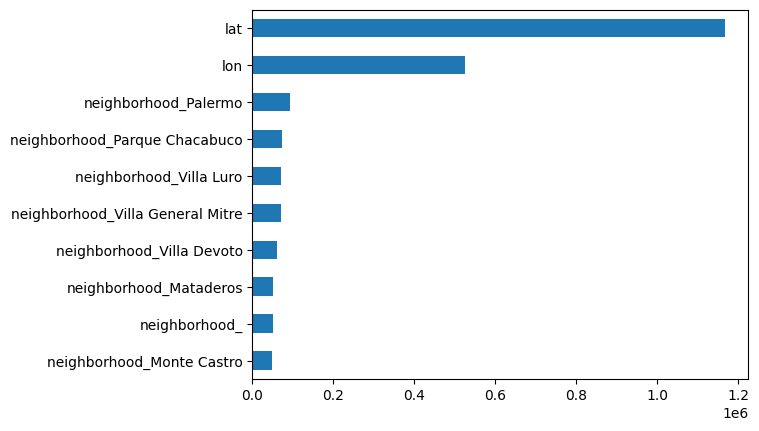

In [ ]:
coefficients = model_lr.named_steps.linearregression.coef_
features = rf.named_steps["onehotencoder"].get_feature_names()
feat_imp = pd.Series(coefficients, index=features)
feat_imp.sort_values(ascending=True).tail(10).plot(kind="barh");

In [ ]:
def make_prediction(area, lat, lon, neighborhood):

    # Creating a dictionary for the new data
    data = {
        "lat": lat,
        "lon": lon,   
        "surface_covered_in_m2": area, 
        "neighborhood": neighborhood
    }
    
    # Create a DataFrame
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted house price: ${prediction}"

In [ ]:
make_prediction(-34.60, -38.46, 110, "Saavedra")

'Predicted house price: $78220.0'

In [ ]:
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique()), value="Boca"),
);

interactive(children=(IntSlider(value=151, description='area', max=290, min=22), FloatSlider(value=-34.6189239…